This notebook performs group level spectral analyses for changes in theta and SWR frequency during trace conditioning. Ideally it will visual each animal side-by-side along with a combined, averaged spectrogram for each task stage.

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
# Load in / initialize sessions
import itertools
animals = ['Finn', 'Han', 'Rey', 'Rose', 'Django', 'Boba', 'Finn2']
sessions = ['recall1', 'recall2']

sess_list = []
for sess_name, animal in itertools.product(sessions, animals):
    try:
        sess_dir = get_session_dir(animal, sess_name)
        sess_list.append(sess_use(sess_dir))
    except IndexError:
        print(f"{animal}_{sess_name} missing - skipped")
print(sess_list[0].recinfo)


filename: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
# Set up for plotting and saving later
if "habituation" in sessions[0]:
    cs_names, cs_types = ['CS-'], ['csn']
elif "training" in sessions[0]:
    cs_names, cs_types = ['CS-', 'CS+'], ['csn', 'cs']
elif "recall" in sessions[0]:
    cs_names, cs_types = ['CS+', 'CS-', 'CS+'], ['cs', 'csn', 'cs2']

group_path = Path('/data2/Trace_FC/Recording_Rats')

In [5]:
# Load in relevant epochs

for sess in sess_list:
    # Artifact epochs
    art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
    sess.art_epochs = Epoch(epochs=None, file=art_epochs_file)

    # CS epochs
    process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
    if sess.basepath.name.find("habituation") >= 0:
        process_cs, process_cs2 = False, False
    elif sess.basepath.name.find('training') >= 0:
        process_cs2 = False
    sess.process_csn, sess.process_cs, sess.process_cs2 = process_csn, process_cs, process_cs2

    for cs_type in ('csn', 'cs', 'cs2'):
        if getattr(sess, f'process_{cs_type}'):
            cs_epochs_file = sess.filePrefix.with_suffix(f".{cs_type}_epochs.npy")
            setattr(sess, f"{cs_type}_epochs", Epoch(epochs=None, file=cs_epochs_file))

    # Ripple and theta epochs + channels
    ripple_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
    theta_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
    sess.theta_epochs = Epoch(epochs=None, file=theta_file)
    sess.theta_channel = sess.theta_epochs.metadata["channels"][0]
    sess.ripple_epochs = Epoch(epochs=None, file=ripple_file)
    sess.ripple_channel = sess.ripple_epochs.metadata["channels"][0]


In [6]:
# Add in info for each session for labeling plots later
for sess in sess_list:
    # save session info
    sess_info = str(sess.basepath).split("/")[-2:]
    sess.animal = sess_info[0]
    sess.sess_name = sess_info[1].split("_")[-1]

In [7]:
# Perform theta wavelet for each session and get peri-CS activity!
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
buffer_sec = (5, 65)
for sess in sess_list:
    print(f"Running theta wavelet on {sess.filePrefix.name}")
    signal = sess.eegfile.get_signal()

    wv_theta = WaveletSg(signal.time_slice(channel_id=sess.theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

    # Get mean wavelet for each session!
    for cs_type in ('csn', 'cs', 'cs2'):
        if getattr(sess, f'process_{cs_type}'):
            print(cs_type)
            cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
            wv_theta_mean = wv_theta.get_pe_mean_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
            setattr(sess, f"wv_theta_mean_{cs_type}", wv_theta_mean)

Running theta wavelet on Finn_recall1_denoised
csn
482 frames between 2035.8 and 2036.2 ignored (sent to nan)
cs
426 frames between 272.9 and 273.2 ignored (sent to nan)
10413 frames between 769.3 and 798.6 ignored (sent to nan)
cs2
Running theta wavelet on Han_recall1
csn
62 frames between 1621.3 and 1621.3 ignored (sent to nan)
cs
cs2
Running theta wavelet on Rey_recall1_denoised
csn
14877 frames between 1951.9 and 1963.8 ignored (sent to nan)
cs
cs2
Running theta wavelet on Rose_recall1_denoised
csn
cs
cs2
Running theta wavelet on Django_recall1_denoised
csn
cs
cs2
Running theta wavelet on Boba_recall1_denoised
csn
cs
2519 frames between 508.0 and 510.0 ignored (sent to nan)
36722 frames between 510.8 and 540.2 ignored (sent to nan)
6876 frames between 534.7 and 540.2 ignored (sent to nan)
cs2
Running theta wavelet on Finn2_recall1_denoised
csn
cs
cs2
Running theta wavelet on Finn_recall2_denoised
csn
cs
cs2
Running theta wavelet on Han_recall2
csn
cs
1391 frames between 509.9 and 5

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

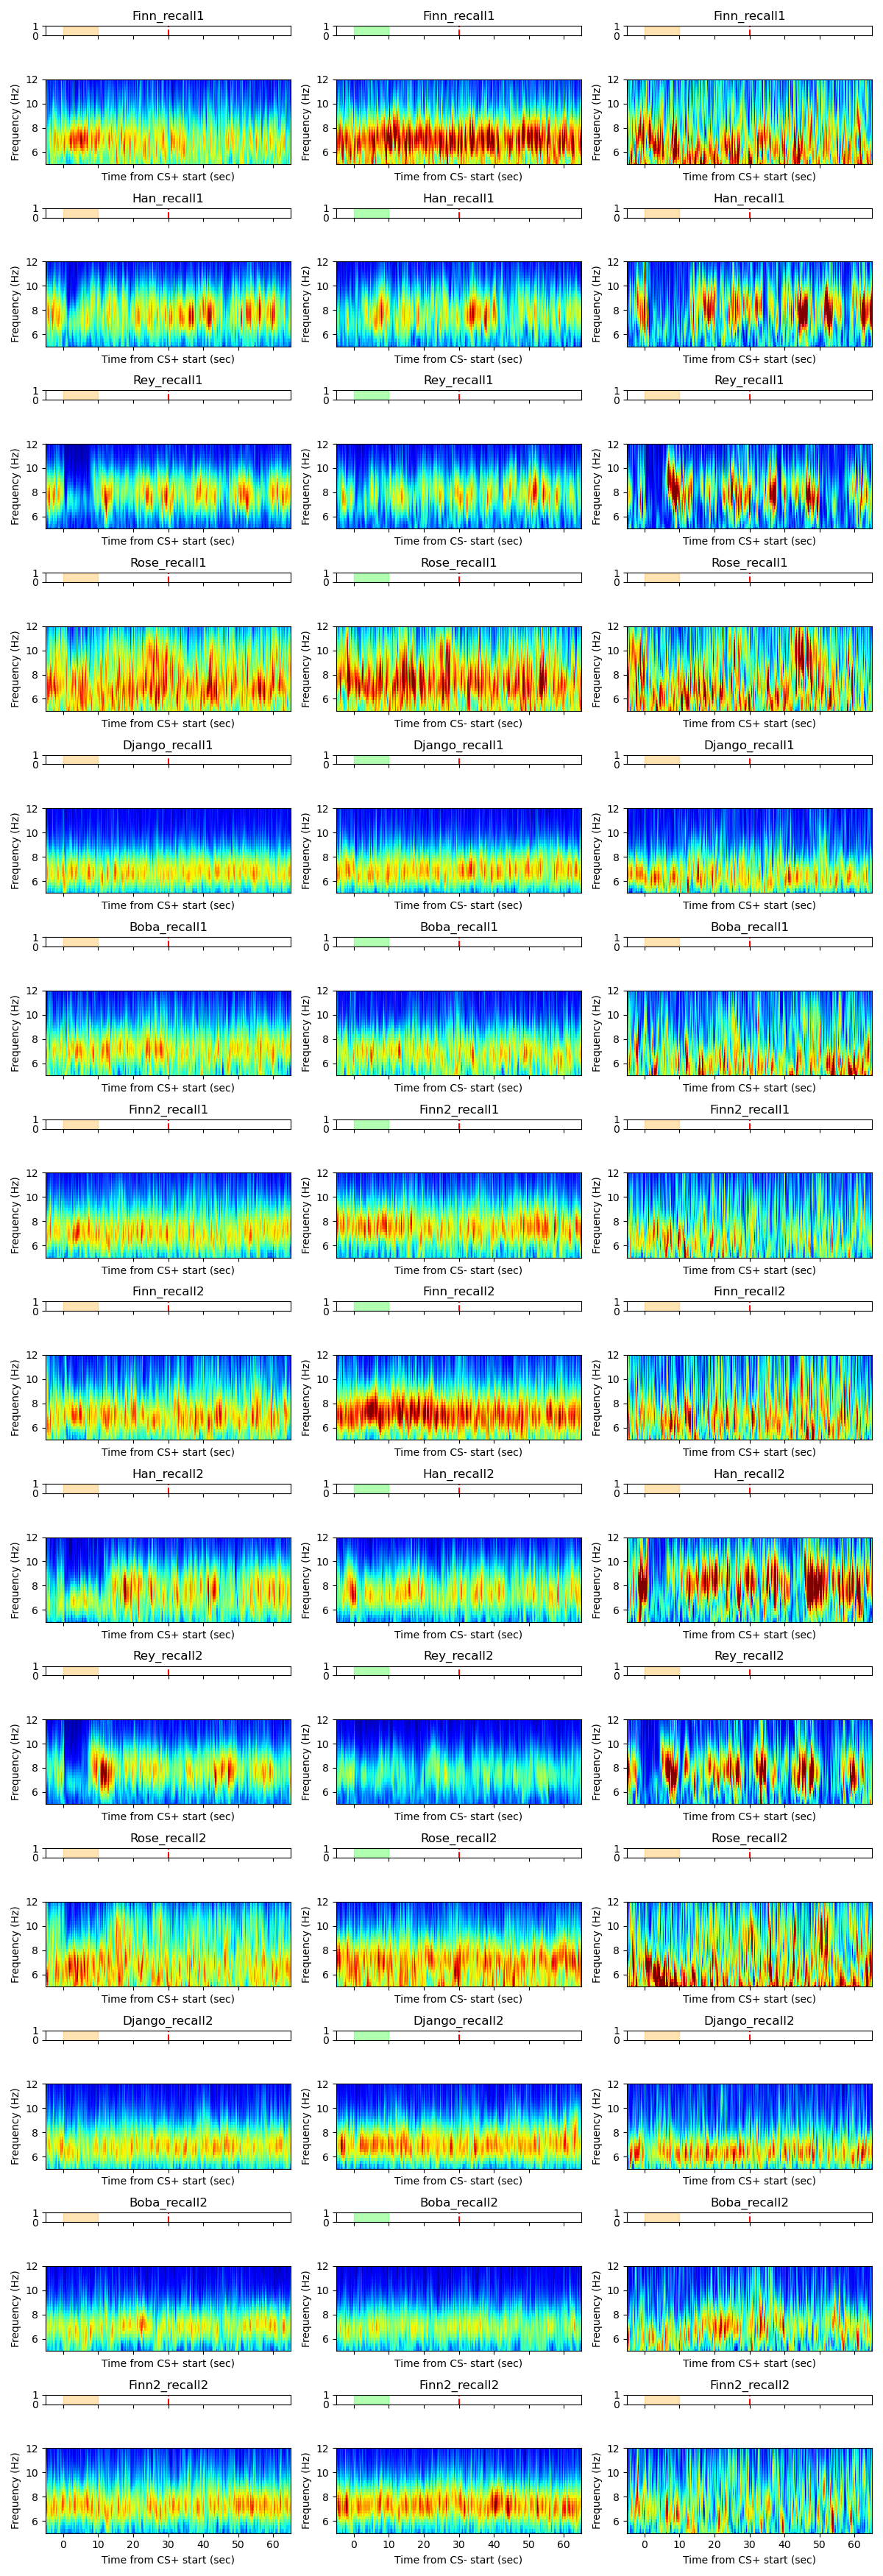

In [8]:
# Now try plotting!
%matplotlib widget
from tracefc.plotting.signals import plot_cs_mean_wavelet

theta_freq_lims = (5, 12)
nsesh = len(sess_list)
ftheta_ind, ax = plt.subplots(nsesh*2, 3, figsize=(12, 2.5*nsesh), height_ratios=[1, 9]*nsesh, sharex=True, layout='tight')

wv_mean_comb = []
for ids, sess in enumerate(sess_list):
    wv_comb_sesh = []
    for idc, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
        cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
        wv_mean_use = getattr(sess, f"wv_theta_mean_{cs_type}")
        wv_comb_sesh.append(wv_mean_use.traces)
        std_sxx = None if idc == 0 else std_sxx
        _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
                                          freq_lims=theta_freq_lims, calc_mean=False, std_sxx=std_sxx, 
                                          ax=ax[range(ids*2, (ids+1)*2), idc])
        ax[ids*2, idc].set_title(f"{sess.animal}_{sess.sess_name}")
    wv_mean_comb.append(wv_comb_sesh)

ftheta_ind.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_theta_ind_plots_{'_'.join(sessions)}.pdf")

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

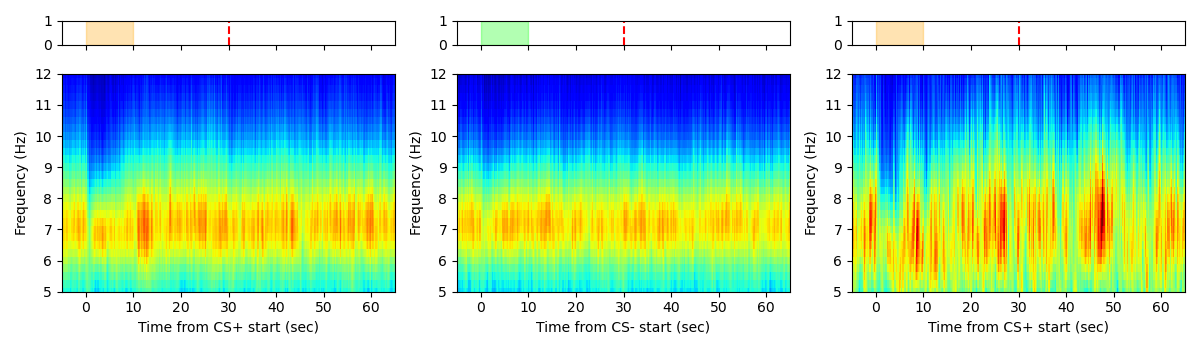

In [9]:
from copy import deepcopy
ftheta_comb, ax = plt.subplots(2, 3, height_ratios = [1, 9], sharex=True, figsize=(12, 3.5), layout='tight')
comb_mean = np.array(wv_mean_comb).mean(axis=0)

for idn, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
    if getattr(sess_list[0], f"process_{cs_type}"):
        wv_mean_use = deepcopy(wv_mean_use)
        wv_mean_use.traces = comb_mean[idn]
        _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
                                                  freq_lims=theta_freq_lims, calc_mean=False, std_sxx=None, ax=ax[:, idn])

ftheta_comb.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_theta_mean_plots_{'_'.join(sessions)}.pdf")

# Ripple-band spectrogram group plots

In [10]:
# Perform theta wavelet for each session and get peri-CS activity!
swr_range = np.arange(125, 275, 5)

buffer_sec = (5, 65)
for sess in sess_list:
    print(f"Running swr wavelet on {sess.filePrefix.name}")
    signal = sess.eegfile.get_signal()

    wv_swr = WaveletSg(signal.time_slice(channel_id=sess.ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

    # Get mean wavelet for each session!
    for cs_type in ('csn', 'cs', 'cs2'):
        if getattr(sess, f'process_{cs_type}'):
            print(cs_type)
            cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
            wv_swr_mean = wv_swr.get_pe_mean_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
            setattr(sess, f"wv_swr_mean_{cs_type}", wv_swr_mean)

Running swr wavelet on Finn_recall1_denoised
csn
482 frames between 2035.8 and 2036.2 ignored (sent to nan)
cs
426 frames between 272.9 and 273.2 ignored (sent to nan)
10413 frames between 769.3 and 798.6 ignored (sent to nan)
cs2
Running swr wavelet on Han_recall1
csn
62 frames between 1621.3 and 1621.3 ignored (sent to nan)
cs
cs2
Running swr wavelet on Rey_recall1_denoised
csn
14877 frames between 1951.9 and 1963.8 ignored (sent to nan)
cs
cs2
Running swr wavelet on Rose_recall1_denoised
csn
cs
cs2
Running swr wavelet on Django_recall1_denoised
csn
cs
cs2
Running swr wavelet on Boba_recall1_denoised
csn
cs
2519 frames between 508.0 and 510.0 ignored (sent to nan)
36722 frames between 510.8 and 540.2 ignored (sent to nan)
6876 frames between 534.7 and 540.2 ignored (sent to nan)
cs2
Running swr wavelet on Finn2_recall1_denoised
csn
cs
cs2
Running swr wavelet on Finn_recall2_denoised
csn
cs
cs2
Running swr wavelet on Han_recall2
csn
cs
1391 frames between 509.9 and 527.5 ignored (sent

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

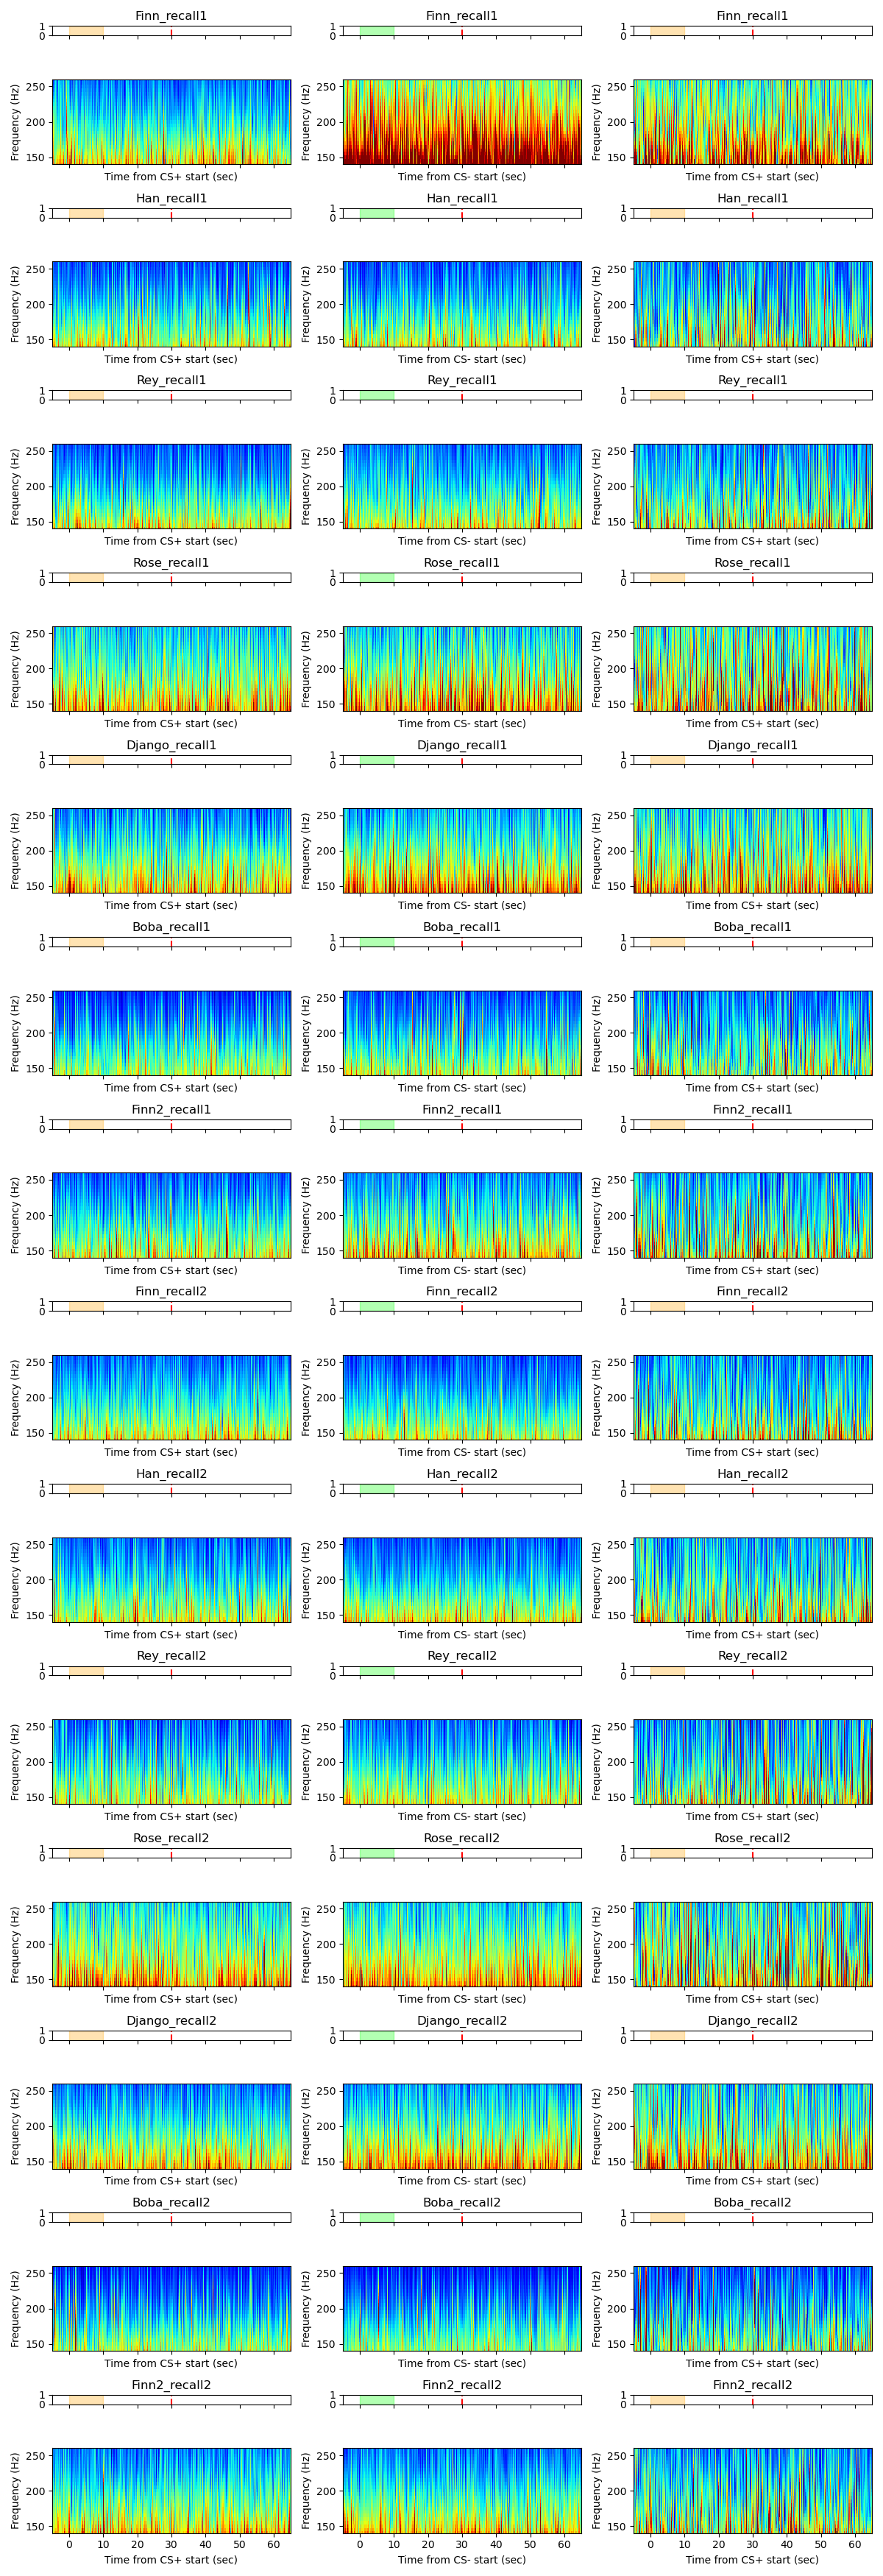

In [11]:
# Now try plotting!
%matplotlib widget
from tracefc.plotting.signals import plot_cs_mean_wavelet

ripple_freq_lims = (140, 260)
nsesh = len(sess_list)
fswr_ind, ax = plt.subplots(nsesh*2, 3, figsize=(12, 2.5*nsesh), height_ratios=[1, 9]*nsesh, sharex=True, layout='tight')

wv_swr_mean_comb = []
for ids, sess in enumerate(sess_list):
    wv_comb_sesh = []
    for idc, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
        cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
        wv_mean_use = getattr(sess, f"wv_swr_mean_{cs_type}")
        wv_comb_sesh.append(wv_mean_use.traces)
        std_sxx = None if idc == 0 else std_sxx
        _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
                                          freq_lims=ripple_freq_lims, calc_mean=False, std_sxx=std_sxx, 
                                          ax=ax[range(ids*2, (ids+1)*2), idc])
        ax[ids*2, idc].set_title(f"{sess.animal}_{sess.sess_name}")
    wv_swr_mean_comb.append(wv_comb_sesh)

fswr_ind.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_SWR_ind_plots_{'_'.join(sessions)}.pdf")

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

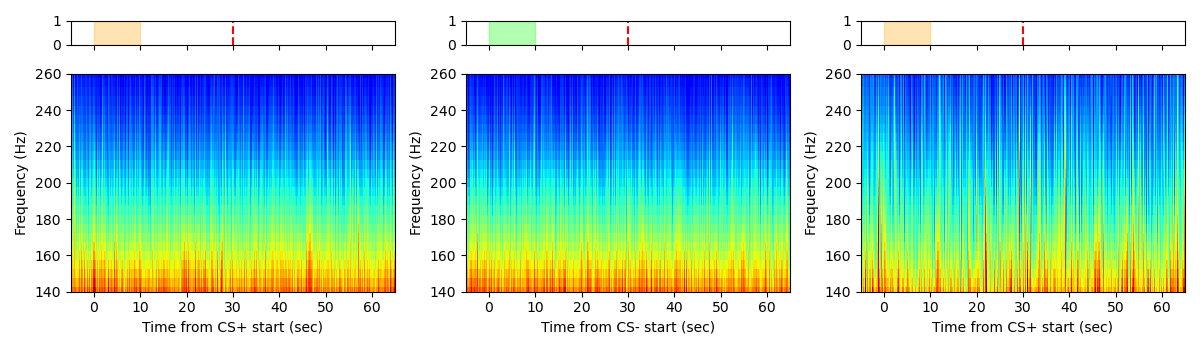

In [12]:
from copy import deepcopy
fswr_comb, ax = plt.subplots(2, 3, height_ratios = [1, 9], sharex=True, figsize=(12, 3.5), layout='tight')
comb_mean = np.array(wv_swr_mean_comb).mean(axis=0)

for idn, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
    if getattr(sess_list[0], f"process_{cs_type}"):
        wv_mean_use = deepcopy(wv_mean_use)
        wv_mean_use.traces = comb_mean[idn]
        _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
                                                  freq_lims=ripple_freq_lims, calc_mean=False, std_sxx=None, 
                                                  ax=ax[:, idn])
fswr_comb.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_SWR_mean_plots_{'_'.join(sessions)}.pdf")

## Save notebook to working directory

In [13]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(group_path, save_append=f"_{'_'.join(sessions)}")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis_Group.ipynb saved to /data2/Trace_FC/Recording_Rats/Spectral_Analysis_Group_recall1_recall2.ipynb
